<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_1_gan_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Mounted at /content/drive
Note: using Google CoLab




1.   stylegan klonlamasının yapılması
2.   Gerekli bağımlılıkları yüklemek için pip aracılığıyla ninja paketini kurun:



In [17]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

fatal: destination path 'stylegan3' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


 StyleGAN içeiğinin görüntülenmesi

In [18]:
!ls /content/stylegan3

avg_spectra.py	 Dockerfile	  gen_video.py	metrics      training
calc_metrics.py  docs		  gui_utils	__pycache__  train.py
dataset_tool.py  environment.yml  legacy.py	README.md    visualizer.py
dnnlib		 gen_images.py	  LICENSE.txt	torch_utils  viz


NVlabs tarafından geliştirilen StyleGAN3 projesinin gen_images.py adlı bir betiği kullanmaktadır. Kod, belirli bir model ağı kullanarak sentetik görüntülerin üretilmesini hedeflemektedir. İ

, belirtilen StyleGAN3 model ağı kullanılarak seeds (6600-6625 aralığındaki rastgele sayılarla) sentetik görüntülerin üretildiği bir işlem gerçekleştirir. Üretilen görüntüler, /content/results klasörüne kaydedilir

In [19]:

URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/"\
      "stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

!python /content/stylegan3/gen_images.py \
    --network={URL} \
  --outdir=/content/results --seeds=6600-6625 

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Generating image for seed 6600 (0/26) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Generating image for seed 6605 (5/26) ...
Generating image for seed 6606 (6/26) ...
Generating image for seed 6607 (7/26) ...
Generating image for seed 6608 (8/26) ...
Generating image for seed 6609 (9/26) ...
Generating image for seed 6610 (10/26) ...
Generating image for seed 6611 (11/26) ...
Generating image for seed 6612 (12/26) ...
Generating image for seed 6613 (13/26) ...
Generating image for seed 6614 (14/26) ...
Generating image for seed 6615 (15/26) ...
Generating image for seed 6616 (16/26) ...
Generating image for seed 661

Oluşturukan resimlerin görüntülenmesi

In [20]:
!ls /content/results

frame-0.png    frame-141.png  frame-183.png  frame-44.png  frame-86.png
frame-100.png  frame-142.png  frame-184.png  frame-45.png  frame-87.png
frame-101.png  frame-143.png  frame-185.png  frame-46.png  frame-88.png
frame-102.png  frame-144.png  frame-186.png  frame-47.png  frame-89.png
frame-103.png  frame-145.png  frame-187.png  frame-48.png  frame-8.png
frame-104.png  frame-146.png  frame-188.png  frame-49.png  frame-90.png
frame-105.png  frame-147.png  frame-189.png  frame-4.png   frame-91.png
frame-106.png  frame-148.png  frame-18.png   frame-50.png  frame-92.png
frame-107.png  frame-149.png  frame-190.png  frame-51.png  frame-93.png
frame-108.png  frame-14.png   frame-191.png  frame-52.png  frame-94.png
frame-109.png  frame-150.png  frame-192.png  frame-53.png  frame-95.png
frame-10.png   frame-151.png  frame-193.png  frame-54.png  frame-96.png
frame-110.png  frame-152.png  frame-194.png  frame-55.png  frame-97.png
frame-111.png  frame-153.png  frame-195.png  frame-56.png  frame-

Uzun süren çalışmalar sonucunda dosya kaybı yaşamamak için drive kopyalaması yapılır

In [21]:
!cp /content/results/* \
    /content/drive/My\ Drive/projects/stylegan3

cp: target '/content/drive/My Drive/projects/stylegan3' is not a directory


Önceden eğitilmiş bir ağ kullanarak belirli bir rastgele tohumdan başlayarak sentetik görüntüler oluşturur. Parametreler aracılığıyla ağın yüklenmesi, üretilecek tohumların belirlenmesi, kesme değeri (truncation), gürültü modu ve çıktı dizini gibi ayarlamalar yapılabilir. Ardından, tohumlara dayalı olarak görüntüler üretilir ve belirtilen çıktı dizinine kaydedilir.

In [22]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', 
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

Böylece, StyleGAN3 modeline ait önceden eğitilmiş ağırlıklar başarıyla indirilir ve yüklenir. Bu ağırlıkların kullanılmasıyla çeşitli sentezleme işlemleri gerçekleştirilebilir ve yüksek kaliteli yüz görüntüleri elde edilebilir.

In [23]:
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


Seed 5000


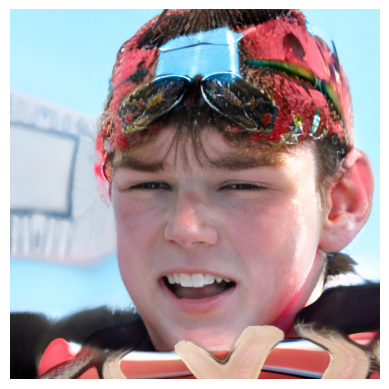

Seed 5001


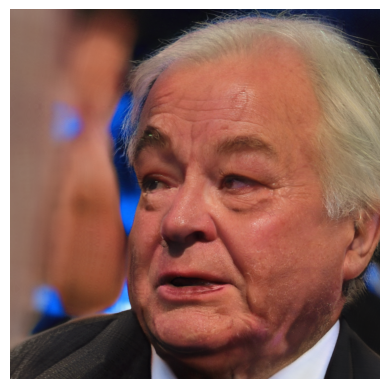

Seed 5002


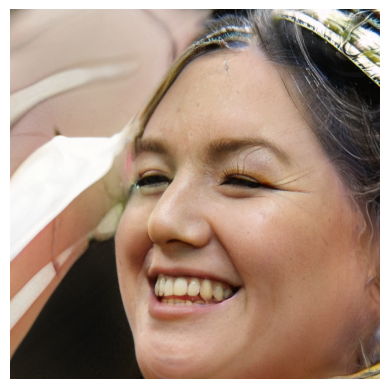

In [24]:
#seed belirleme :farklı görseller elde etmek için bu aralıkları değiştirebilirsiniz 
SEED_FROM = 5000
SEED_TO = 5003

# Bu aralıklar için resimlerin üretlmesi .
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)


expand_seed adlı bir fonksiyon tanımlar. Bu fonksiyon, belirtilen tohumların ve vektör boyutunun kullanıldığı bir liste oluşturur. Her bir tohum için rastgele sayılar kullanılarak vektör oluşturulur ve sonuç listesine eklenir.


In [25]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [1192+1,1192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
(1, 512)


Oluşturma
Seçilen tohumları ve her birine ulaşmak için alınacak adım sayısını belirlemek için SEEDS ve STEPS değişkenlerini kullanın.


In [26]:

SEEDS = [5624,5618,5616] 

STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

Seed 5624:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 5618:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

video hazır,indirilir 

In [27]:
from IPython.display import HTML

video_path = "/content/movie.mp4"
video_html = f'<video controls autoplay><source src="{video_path}" type="video/mp4"></video>'
HTML(video_html)


In [28]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>